<a href="https://colab.research.google.com/github/Lokeshgadhi/introonpandas/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing values in each column:
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64

Summary statistics:
            Balance    Qual_miles    cc1_miles    cc2_miles    cc3_miles  \
count  3.999000e+03   3999.000000  3999.000000  3999.000000  3999.000000   
mean   7.360133e+04    144.114529     2.059515     1.014504     1.012253   
std    1.007757e+05    773.663804     1.376919     0.147650     0.195241   
min    0.000000e+00      0.000000     1.000000     1.000000     1.000000   
25%    1.852750e+04      0.000000     1.000000     1.000000     1.000000   
50%    4.309700e+04      0.000000     1.000000     1.000000     1.000000   
75%    9.240400e+04      0.000000     3.000000     1.000000     1.000000   
max    1.704838e+06  11148.000000     5.000000     3.000000     5.000000  

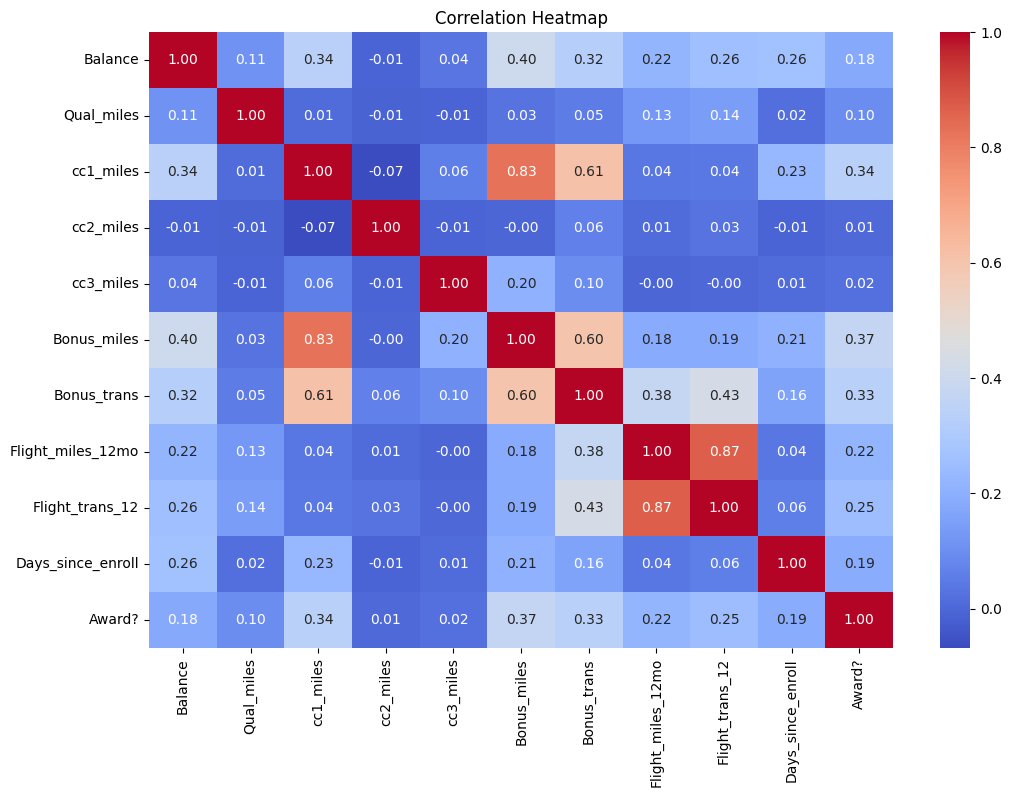

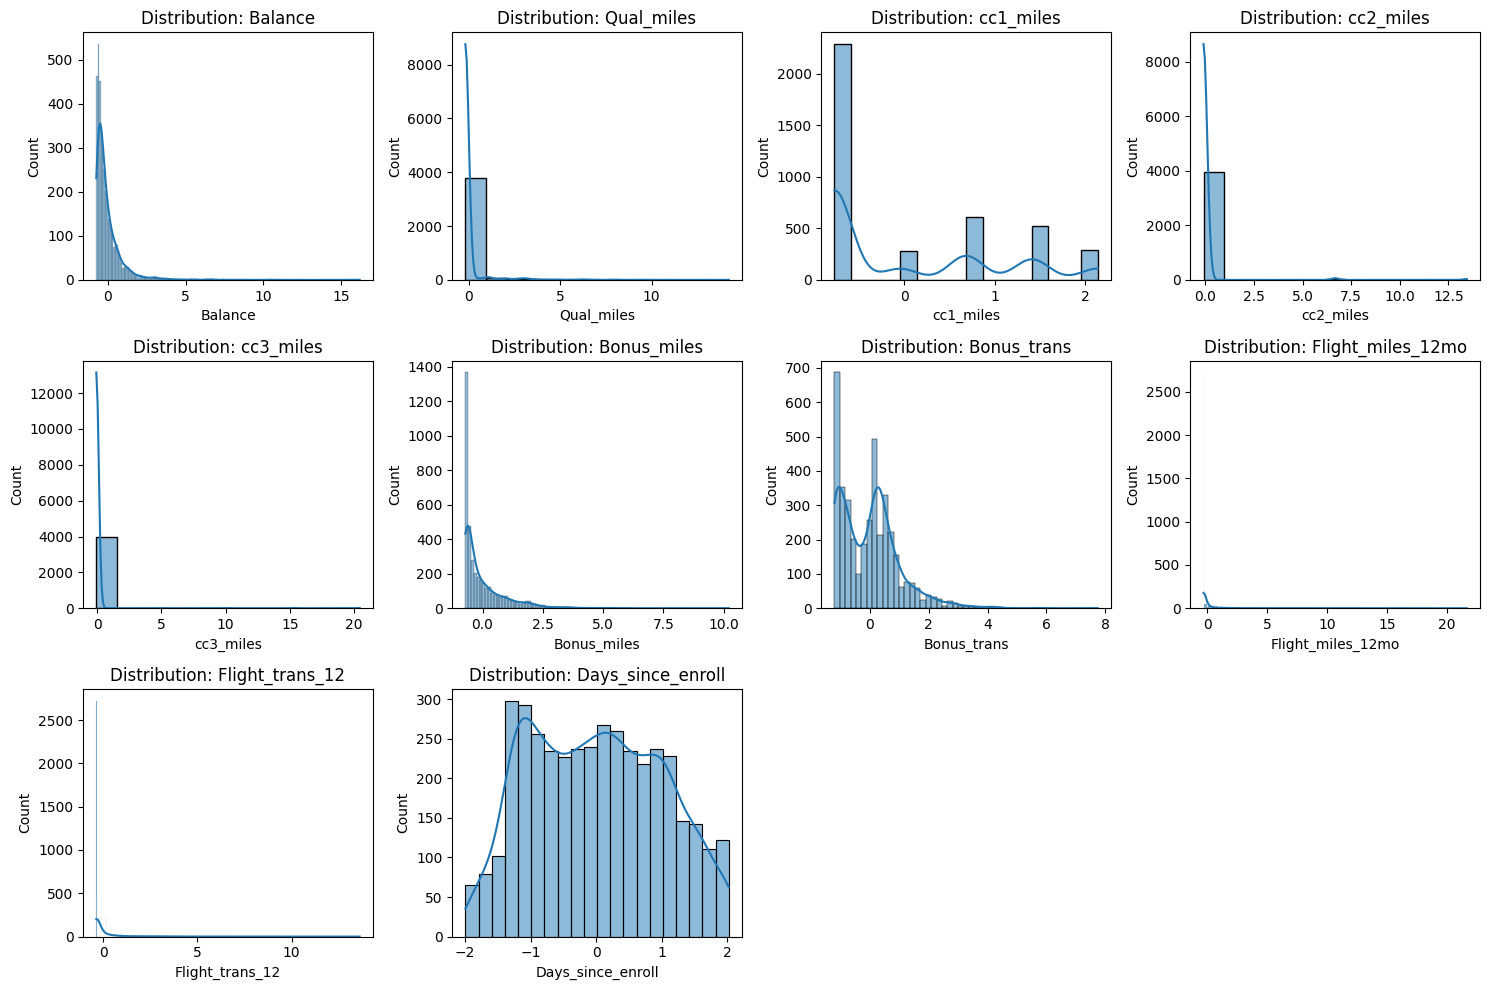

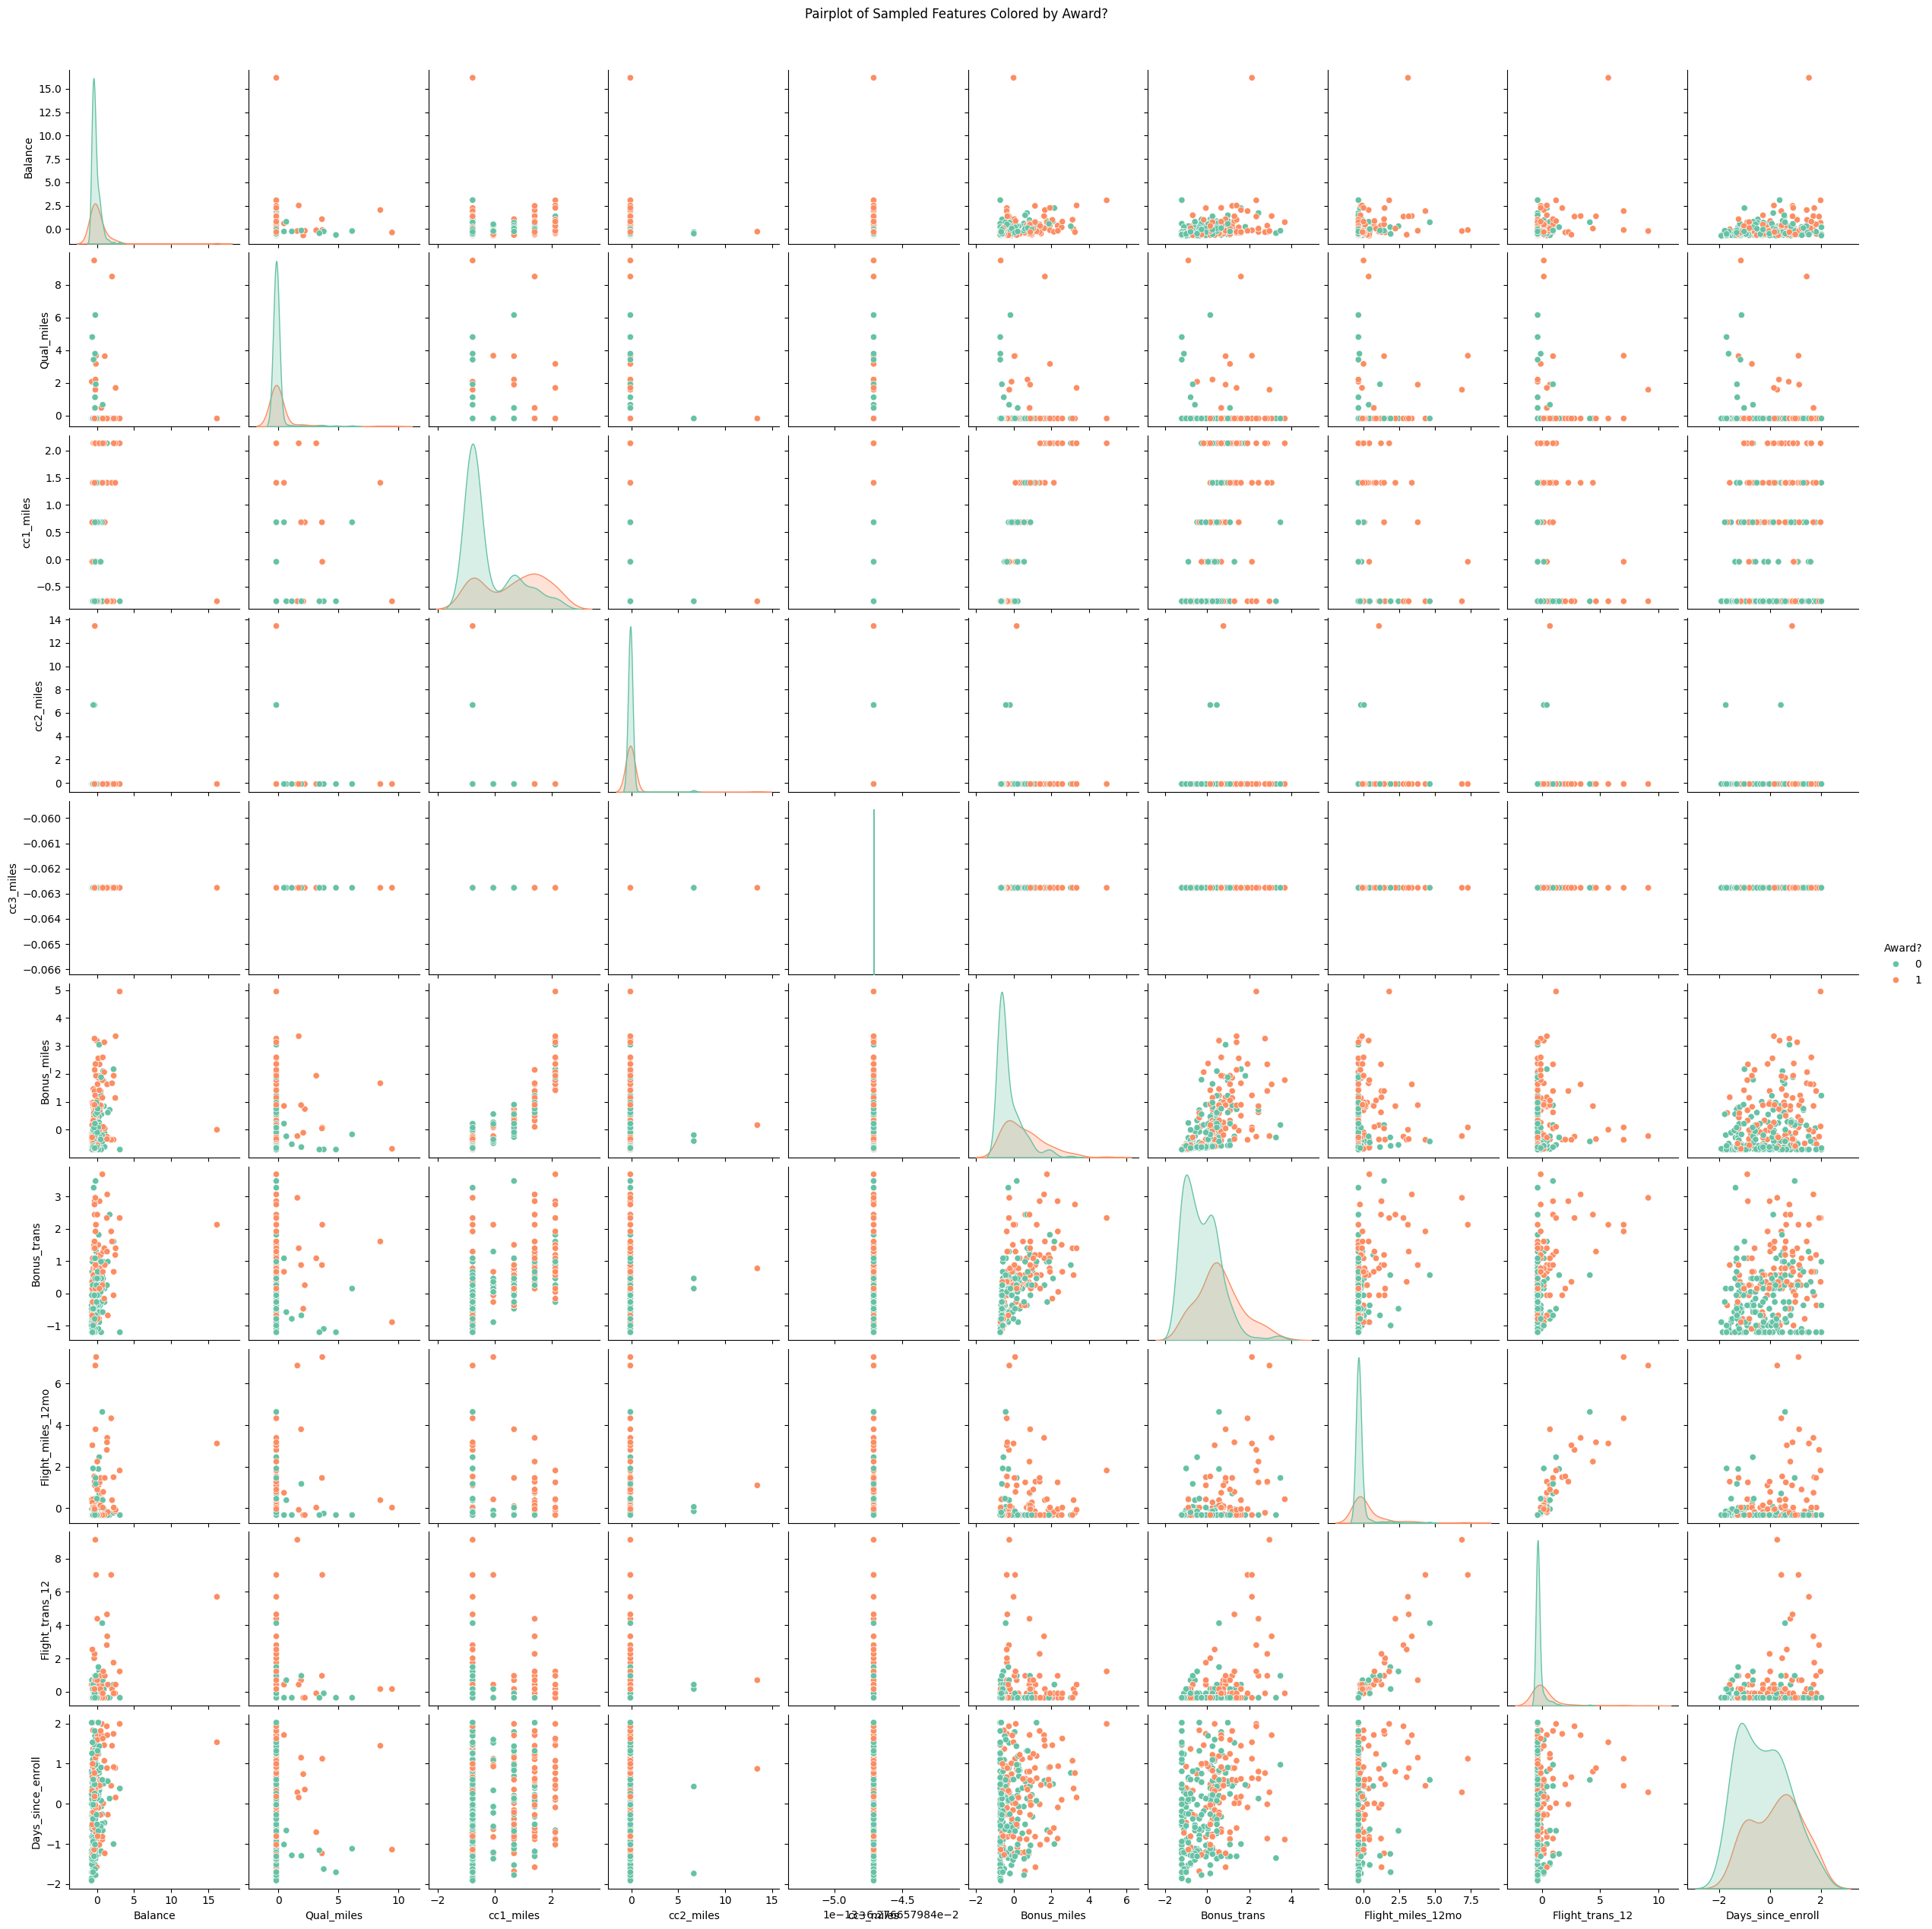

In [10]:
# Import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = "EastWestAirlines.xlsx"
excel_file = pd.ExcelFile(file_path)
df = excel_file.parse('data')

# Drop identifier column
df_clean = df.drop(['ID#'], axis=1)

# Check for missing values
print("Missing values in each column:")
print(df_clean.isnull().sum())

# Display basic statistics
print("\nSummary statistics:")
print(df_clean.describe())

# Scaling features (excluding 'Award?')
features = df_clean.drop(['Award?'], axis=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Create a scaled DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=features.columns)

# Combine with label column for EDA
df_scaled['Award?'] = df_clean['Award?']

# =========================
# Exploratory Data Analysis
# =========================

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_scaled.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Distribution plots for key features
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_scaled.columns[:-1]):
    plt.subplot(3, 4, i + 1)
    sns.histplot(df_scaled[column], kde=True)
    plt.title(f'Distribution: {column}')
plt.tight_layout()
plt.show()

# Pairplot to observe possible clustering patterns (subset for performance)
sns.pairplot(df_scaled.sample(300), hue='Award?', palette="Set2")
plt.suptitle("Pairplot of Sampled Features Colored by Award?", y=1.02)
plt.show()


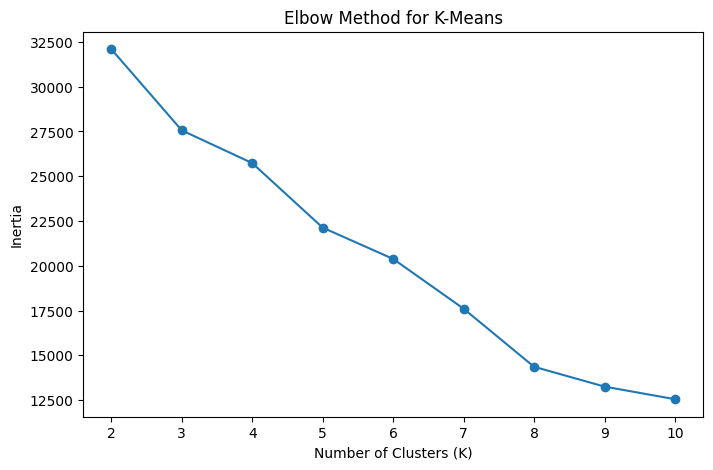

KMeans Silhouette Score: 0.27453067999744063


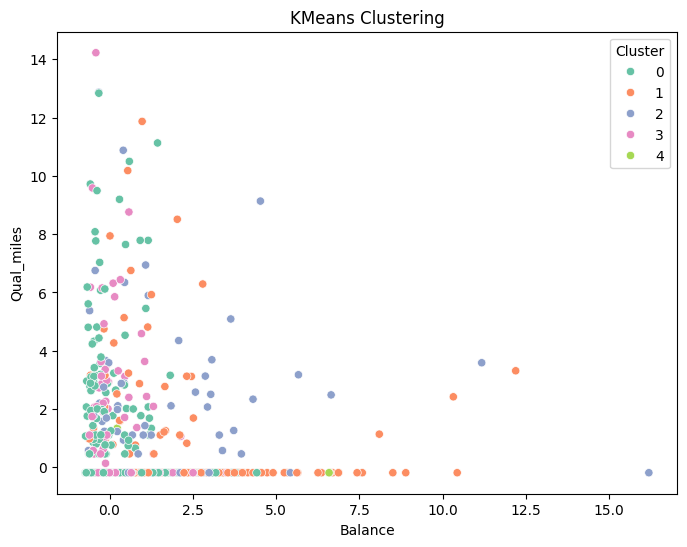

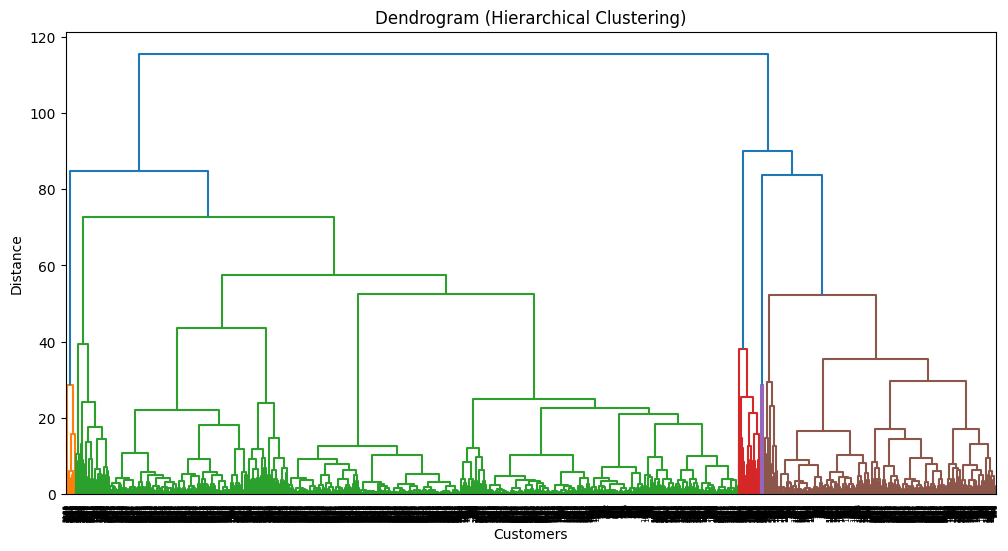

Hierarchical Silhouette Score: 0.32701816589484084


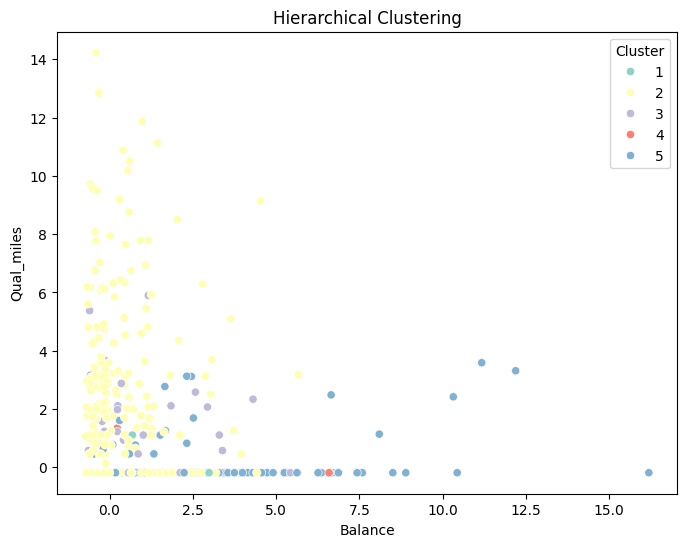

DBSCAN unique clusters: [-1  0  1]
DBSCAN Silhouette Score (excluding noise): 0.6246153405235202


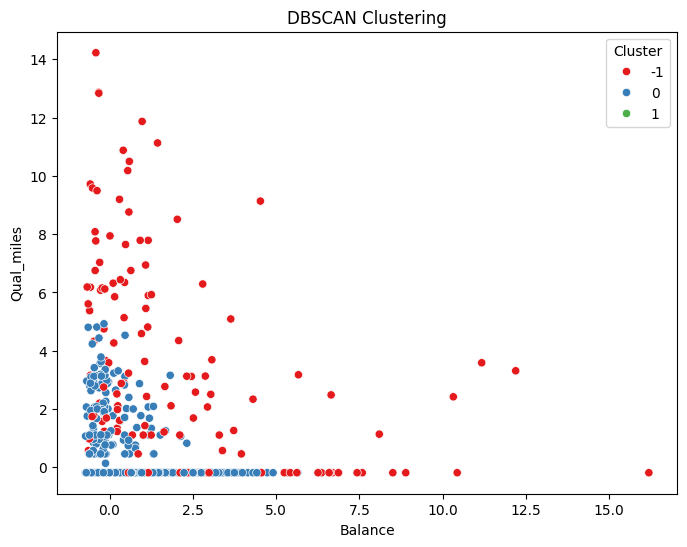

In [11]:
# Required Libraries
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use the previously scaled data (excluding the 'Award?' column for clustering)
X = df_scaled.drop('Award?', axis=1)

# =======================
# 1. K-Means Clustering
# =======================
# Elbow method to find optimal k
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')
plt.show()

# Apply KMeans with optimal K (e.g., 5 from Elbow Curve)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Evaluate KMeans
print("KMeans Silhouette Score:", silhouette_score(X, kmeans_labels))

# Visualize KMeans Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=kmeans_labels, palette='Set2')
plt.title("KMeans Clustering")
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])
plt.legend(title='Cluster')
plt.show()

# ==========================
# 2. Hierarchical Clustering
# ==========================
# Dendrogram
plt.figure(figsize=(12, 6))
dend = dendrogram(linkage(X, method='ward'))
plt.title("Dendrogram (Hierarchical Clustering)")
plt.xlabel("Customers")
plt.ylabel("Distance")
plt.show()

# Apply Agglomerative Clustering
hier_labels = fcluster(linkage(X, method='ward'), t=5, criterion='maxclust')

# Evaluate
print("Hierarchical Silhouette Score:", silhouette_score(X, hier_labels))

# Visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=hier_labels, palette='Set3')
plt.title("Hierarchical Clustering")
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])
plt.legend(title='Cluster')
plt.show()

# ===================
# 3. DBSCAN Clustering
# ===================
dbscan = DBSCAN(eps=1.8, min_samples=10)
dbscan_labels = dbscan.fit_predict(X)

# Check unique clusters
print("DBSCAN unique clusters:", np.unique(dbscan_labels))

# Evaluate DBSCAN (filter -1 noise points if necessary)
filtered_labels = dbscan_labels[dbscan_labels != -1]
filtered_X = X[dbscan_labels != -1]
if len(filtered_labels) > 1:
    print("DBSCAN Silhouette Score (excluding noise):", silhouette_score(filtered_X, filtered_labels))
else:
    print("DBSCAN found too few clusters for silhouette score.")

# Visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=dbscan_labels, palette='Set1')
plt.title("DBSCAN Clustering")
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])
plt.legend(title='Cluster')
plt.show()


Cluster Analysis and Interpretation:
•	Analyse the clusters generated by each clustering algorithm and interpret the characteristics of each cluster. Write you insights in few comments.

1. K-Means Clustering (5 Clusters)
Insights:

Cluster 0: Contains customers with moderate balances and few flight miles; likely average spenders with low loyalty.

Cluster 1: High Bonus Miles and high balance; possibly frequent fliers using loyalty programs.

Cluster 2: Low everything – low balance, no bonus/flight miles; possibly new or inactive customers.

Cluster 3: Small group with extreme balances and Bonus Miles; represents elite or premium customers.

Cluster 4: High Flight miles but moderate Bonus Miles; these may be business travelers flying often but not maximizing rewards.

 2.
  Hierarchical Clustering (5 Clusters, Ward Linkage)
Insights:

Similar clusters as K-Means, though the boundaries are less distinct.

One cluster forms early with low activity customers – potentially useful for targeting with promotional offers.

Higher linkage distance in dendrogram shows greater diversity among customers.

 3. DBSCAN (Density-Based)
Insights:

DBSCAN could detect dense clusters and identify noise (outliers).

Detected smaller groups of tightly packed points (frequent fliers or promotional account holders).

A large number of customers marked as noise (-1), indicating they don't form dense regions — common in varied customer behavior datasets.

More robust to outliers but sensitive to parameter tuning (eps and min_samples).



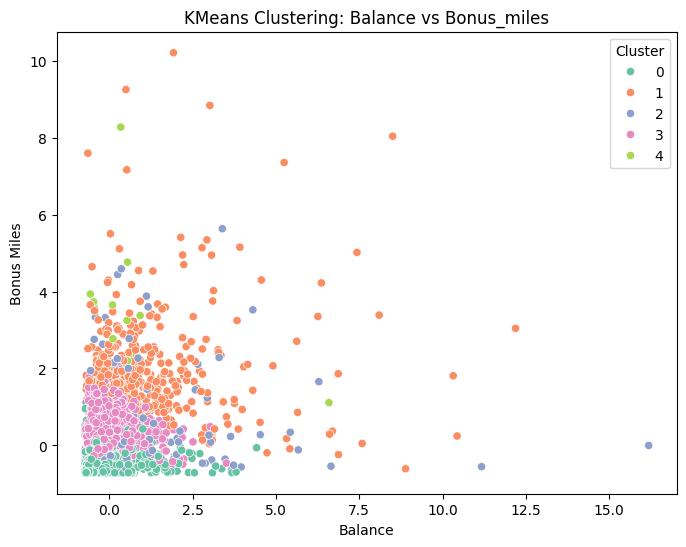

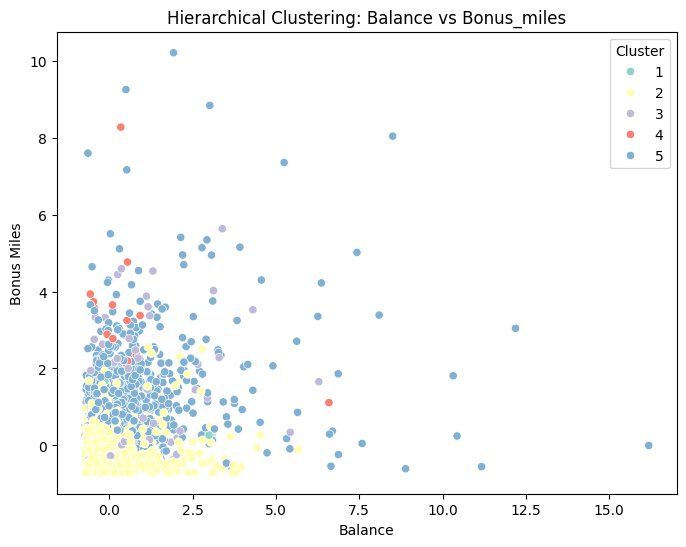

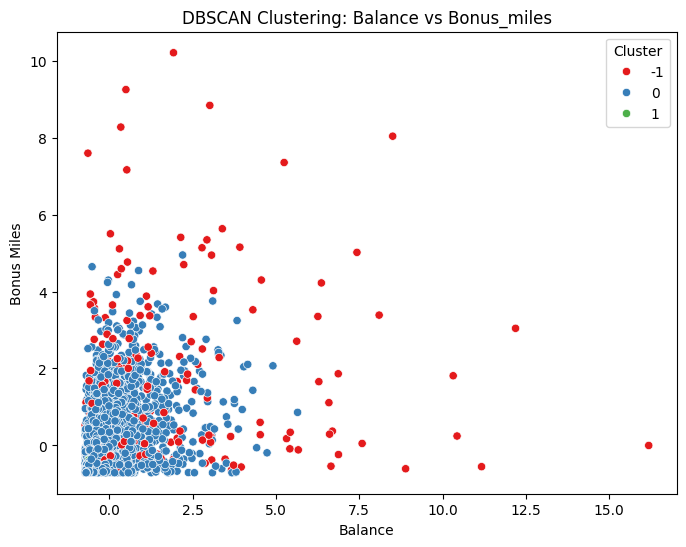

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add cluster labels to the scaled DataFrame
df_scaled['KMeans_Cluster'] = kmeans_labels
df_scaled['Hierarchical_Cluster'] = hier_labels
df_scaled['DBSCAN_Cluster'] = dbscan_labels

# KMeans Clustering Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_scaled, x='Balance', y='Bonus_miles', hue='KMeans_Cluster', palette='Set2')
plt.title('KMeans Clustering: Balance vs Bonus_miles')
plt.xlabel('Balance')
plt.ylabel('Bonus Miles')
plt.legend(title='Cluster')
plt.show()

# Hierarchical Clustering Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_scaled, x='Balance', y='Bonus_miles', hue='Hierarchical_Cluster', palette='Set3')
plt.title('Hierarchical Clustering: Balance vs Bonus_miles')
plt.xlabel('Balance')
plt.ylabel('Bonus Miles')
plt.legend(title='Cluster')
plt.show()

# DBSCAN Clustering Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_scaled, x='Balance', y='Bonus_miles', hue='DBSCAN_Cluster', palette='Set1')
plt.title('DBSCAN Clustering: Balance vs Bonus_miles')
plt.xlabel('Balance')
plt.ylabel('Bonus Miles')
plt.legend(title='Cluster')
plt.show()


In [13]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np

# Assume X is your scaled feature set (without 'Award?')
# X = df_scaled.drop('Award?', axis=1)

# --- K-Means ---
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
kmeans_score = silhouette_score(X, kmeans_labels)

# --- Hierarchical Clustering ---
linkage_matrix = linkage(X, method='ward')
hier_labels = fcluster(linkage_matrix, t=5, criterion='maxclust')
hier_score = silhouette_score(X, hier_labels)

# --- DBSCAN ---
dbscan = DBSCAN(eps=1.8, min_samples=10)
dbscan_labels = dbscan.fit_predict(X)

# Filter out noise points for silhouette score
mask = dbscan_labels != -1
if len(set(dbscan_labels[mask])) > 1:
    dbscan_score = silhouette_score(X[mask], dbscan_labels[mask])
else:
    dbscan_score = "Not enough clusters to evaluate"

# --- Print Results ---
print("=== Silhouette Scores ===")
print(f"K-Means Clustering Score      : {kmeans_score:.4f}")
print(f"Hierarchical Clustering Score: {hier_score:.4f}")
print(f"DBSCAN Clustering Score      : {dbscan_score}")


=== Silhouette Scores ===
K-Means Clustering Score      : 0.2745
Hierarchical Clustering Score: 0.3270
DBSCAN Clustering Score      : 0.6246153405235202
